In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Jan  9 08:04:08 2020
@author: nageshsinghchauhan
"""

# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import missingno as msno

#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
#%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#import the necessary modelling algos.
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV

#preprocess.
from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.impute import SimpleImputer as Imputer

In [8]:
train=pd.read_csv("voice.csv")

df=train.copy()
df.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male



meanfreq: mean frequency (in kHz)  
sd: standard deviation of frequency  
median: median frequency (in kHz)  
Q25: first quantile (in kHz)  
Q75: third quantile (in kHz)  
IQR: interquantile range (in kHz)  
skew: skewness (see note in specprop description)  
kurt: kurtosis (see note in specprop description)  
sp.ent: spectral entropy  
sfm: spectral flatness  
mode: mode frequency  
centroid: frequency centroid (see specprop)  
peakf: peak frequency (frequency with highest energy)  
meanfun: average of fundamental frequency measured across acoustic signal  
minfun: minimum fundamental frequency measured across acoustic signal  
maxfun: maximum fundamental frequency measured across acoustic signal  
meandom: average of dominant frequency measured across acoustic signal  
mindom: minimum of dominant frequency measured across acoustic signal  
maxdom: maximum of dominant frequency measured across acoustic signal  
dfrange: range of dominant frequency measured across acoustic signal  
modindx: modulation index. Calculated as the accumulated absolute difference between adjacent measurements of fundamental frequencies divided by the frequency range  
label: male or female  
Note that we have 3168 voice samples and for each of sample 20 different acoustic properties are recorded. Finally the 'label' column is the target variable which we have to predict which is the gender of the person.  

In [9]:
# check for null values.
df.isnull().any()  

meanfreq    False
sd          False
median      False
Q25         False
Q75         False
IQR         False
skew        False
kurt        False
sp.ent      False
sfm         False
mode        False
centroid    False
meanfun     False
minfun      False
maxfun      False
meandom     False
mindom      False
maxdom      False
dfrange     False
modindx     False
label       False
dtype: bool

<AxesSubplot:>

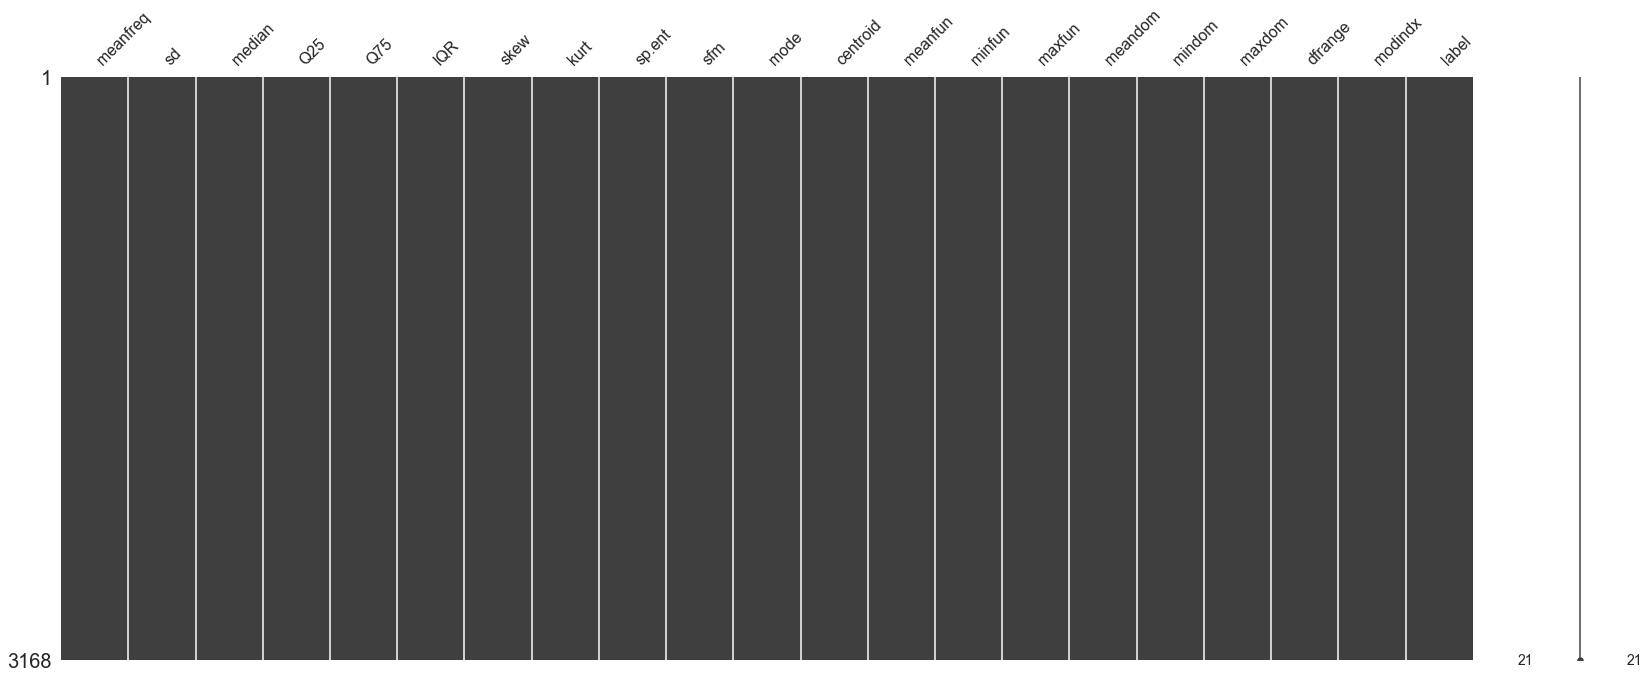

In [10]:
msno.matrix(df)  # just to visualize. no missing value.

Number of data points remaining if outliers removed :  3104


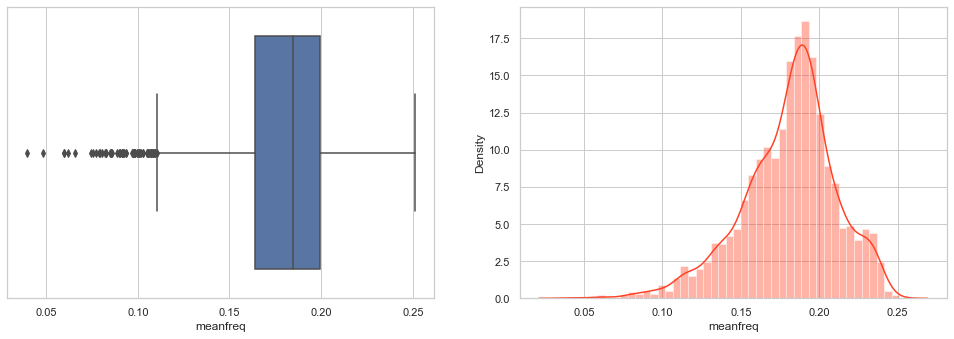

In [13]:
# To detect the outliers I have used the standard 1.5 InterQuartileRange (IQR) rule 
#which states that any observation lesser than 'first quartile - 1.5 IQR' or greater than 'third quartile +1.5 IQR' is an outlier.
# A = [2,3,4,5,6,7] 
# IQR : interquartile range = Median of upper half - Median of lower half = 6 - 3 = 3 
def calc_limits(feature):
    q1,q3=df[feature].quantile([0.25,0.75])
    iqr=q3-q1
    rang=1.5*iqr
    return(q1-rang,q3+rang)
def plot(feature):
    fig,axes=plt.subplots(1,2)
    sns.boxplot(data=df,x=feature,ax=axes[0])
    sns.distplot(a=df[feature],ax=axes[1],color='#ff4125')
    fig.set_size_inches(15,5)
    
    lower,upper = calc_limits(feature)
    l=[df[feature] for i in df[feature] if i>lower and i<upper] 
    print("Number of data points remaining if outliers removed : ",len(l))

plot('meanfreq')

In [15]:
## INFERENCES FROM THE PLOT--
### 1) First of all note that the values are in compliance with that observed from describe method data frame..
### 2) Note that we have a couple of outliers w.r.t. to 1.5 quartile rule (reprsented by a 'dot' in the box plot).Removing these data points or outliers leaves us with around 3104 values.
### 3) Also note from the distplot that the distribution seems to be a bit -ve skewed hence we can normalize to make the distribution a bit more symmetric.
### 4) LASTLY NOTE THAT A LEFT TAIL DISTRIBUTION HAS MORE OUTLIERS ON THE SIDE BELOW TO Q1 AS EXPECTED AND A RIGHT TAIL HAS ABOVE THE Q3.

Number of data points remaining if outliers removed :  3158
Number of data points remaining if outliers removed :  3059
Number of data points remaining if outliers removed :  3135
Number of data points remaining if outliers removed :  3158
Number of data points remaining if outliers removed :  2938
Number of data points remaining if outliers removed :  2836
Number of data points remaining if outliers removed :  3168
Number of data points remaining if outliers removed :  3168


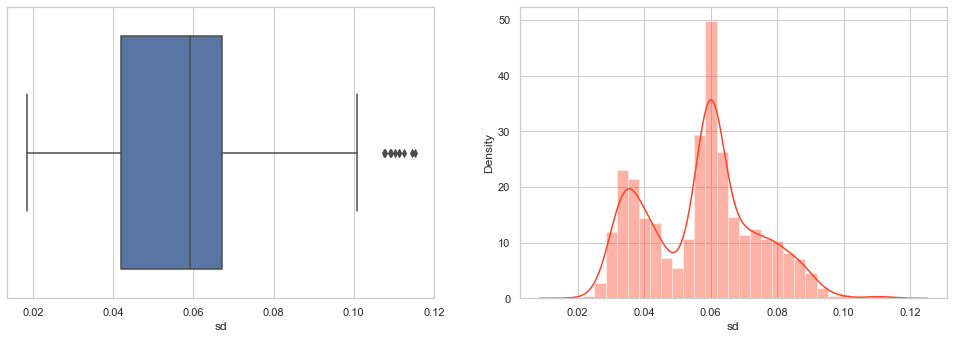

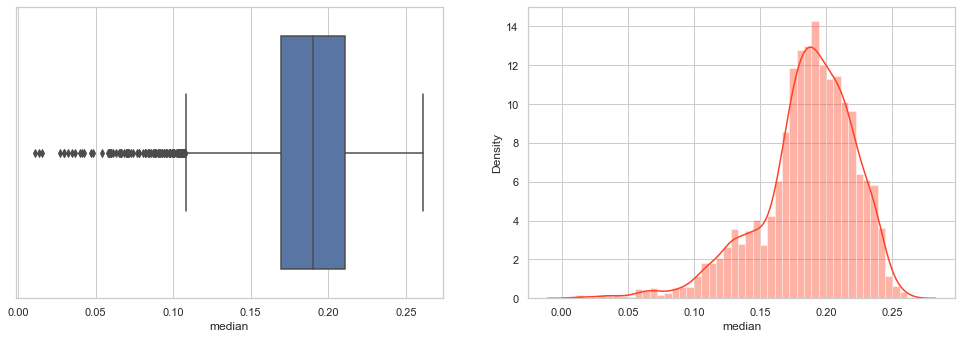

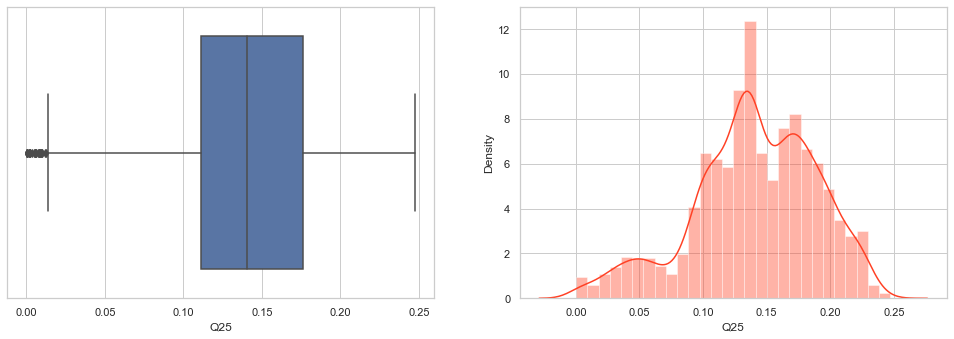

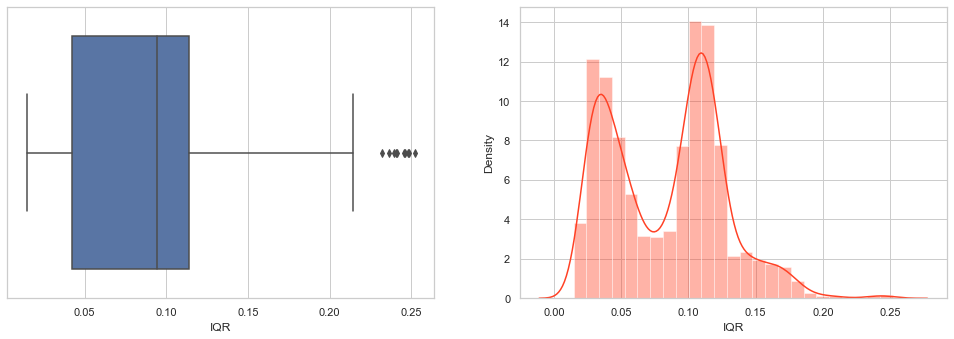

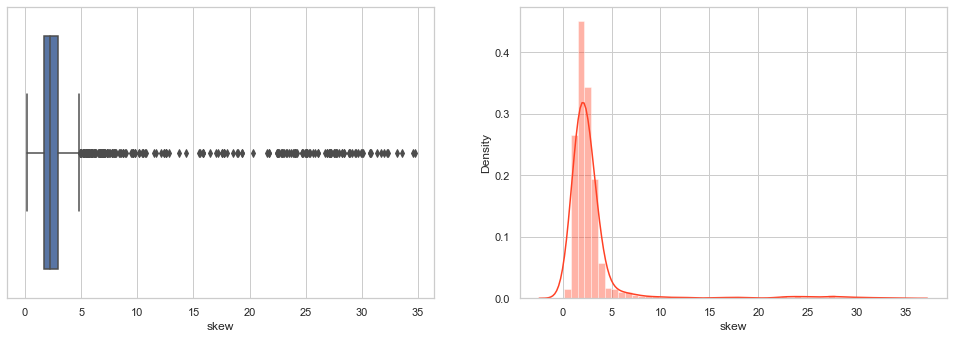

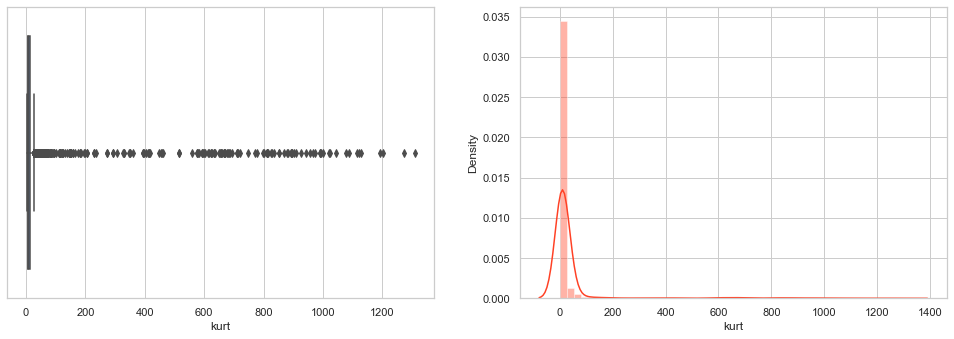

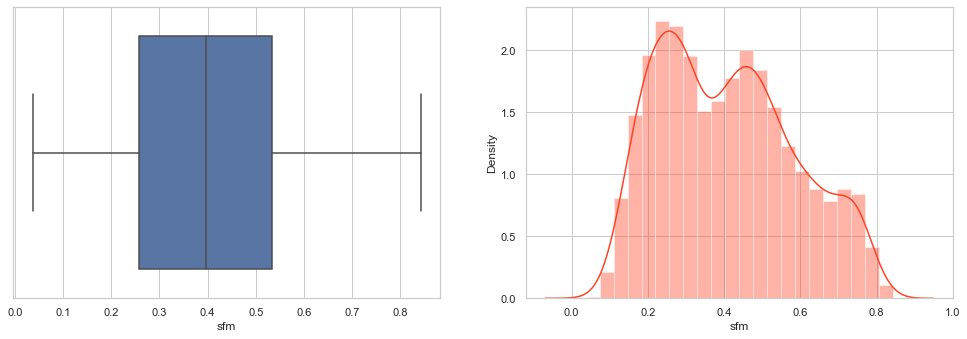

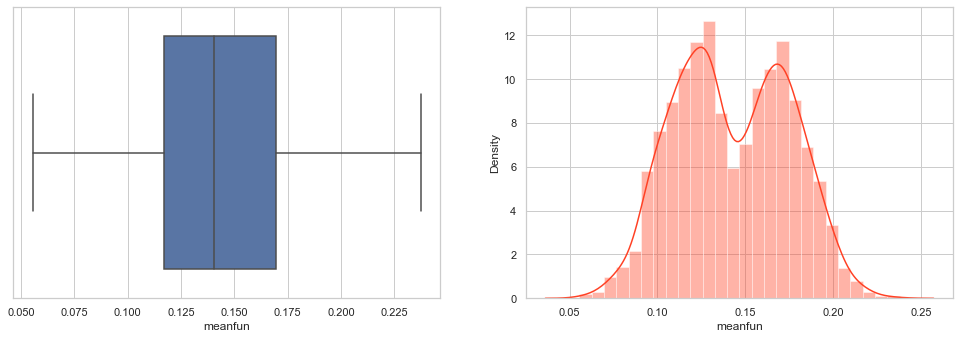

In [14]:
#Similar other plots can be inferenced.¶
plot('sd')

plot('median')

plot('Q25')

plot('IQR')

plot('skew')

plot('kurt')
plot('sfm')

plot('meanfun')

male      1584
female    1584
Name: label, dtype: int64

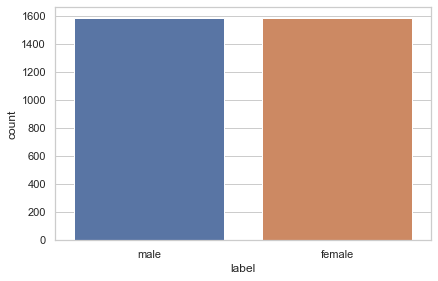

In [16]:
#plot target variable
sns.countplot(data=df,x='label')
df['label'].value_counts()

<AxesSubplot:>

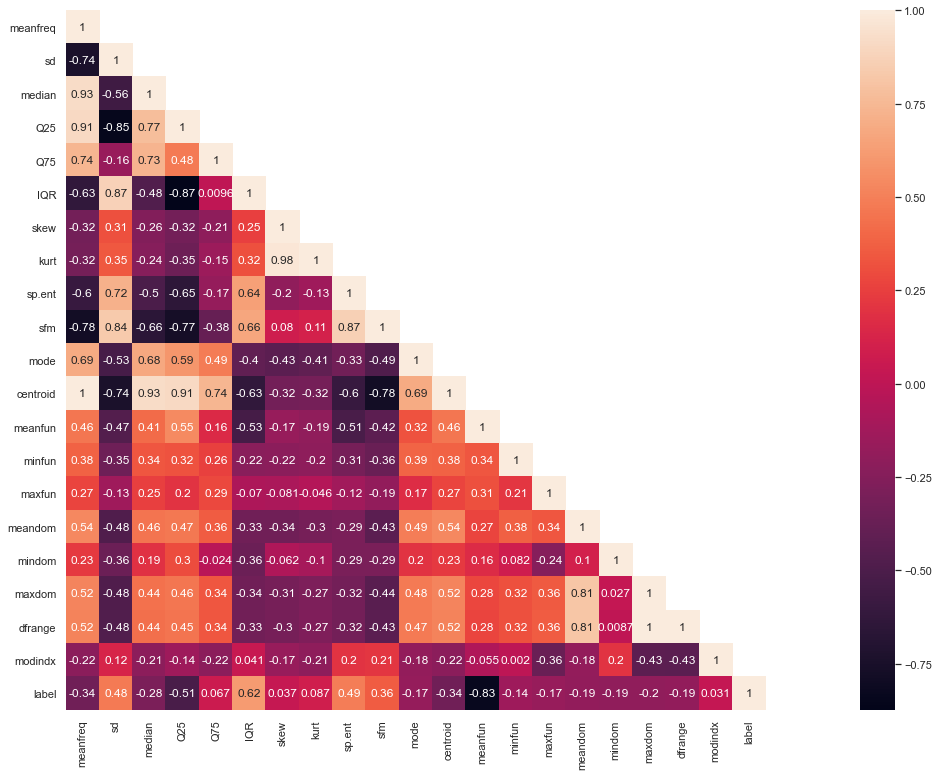

In [17]:
temp = []
for i in df.label:
    if i == 'male':
        temp.append(1)
    else:
        temp.append(0)
df['label'] = temp
#corelation matrix.
cor_mat= df[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

In [18]:
## SOME INFERENCES FROM THE ABOVE HEATMAP--
## 1) Mean frequency is moderately related to label.
## 2) IQR and label tend to have a strong positive corelation.
## 3) Spectral entropy is also quite highly corelated with the label while sfm is moderately related with label.
## 4) skewness and kurtosis aren't much related with label.
## 5) meanfun is highly negatively corelated with the label.
## 6) Centroid and median have a high positive corelationas expected from their formulae.
## 7) ALSO NOTE THAT MEANFREQ AND CENTROID ARE EXACTLY SAME FEATURES AS PER FORMULAE AND VALUES ALSO. HENCE THEIR CORELATION IS PERFCET 1. IN THAT CASE WE CAN DROP ANY COLUMN. note that centroid in general has a high degree of corelation with most of the other features.
## SO I WILL DROP THE 'CENTROID' COLUMN.
## 8) sd is highly positively related to sfm and so is sp.ent to sd.
## 9) kurt and skew are also highly corelated.
## 10) meanfreq is highly related to medaina s well as Q25.
## 11) IQR is highly corelated to sd.
## 12) Finally self relation ie of a feature to itself is equal to 1 as expected.

In [19]:
df.drop('centroid',axis=1,inplace=True)

In [20]:
# removal of any data point which is an outlier for any fetaure.
for col in df.columns:
    lower,upper=calc_limits(col)
    df = df[(df[col] >lower) & (df[col]<upper)]

df.shape


(1636, 20)

In [21]:
#Dropping the features
#I have dropped some columns which according to my analysis proved to be less useful or redundant.

temp_df=df.copy()

temp_df.drop(['skew','kurt','mindom','maxdom'],axis=1,inplace=True) # only one of maxdom and dfrange.
temp_df.head(10)

,meanfreq,sd,median,Q25,Q75,IQR,sp.ent,sfm,mode,meanfun,minfun,maxfun,meandom,dfrange,modindx,label
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,0.963322,0.727232,0.083878,0.088965,0.017798,0.250000,0.201497,0.554688,0.247119,1
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,0.971955,0.783568,0.104261,0.106398,0.016931,0.266667,0.712812,5.476562,0.208274,1
5,0.132786,0.079557,0.119090,0.067958,0.209592,0.141634,0.963181,0.738307,0.112555,0.110132,0.017112,0.253968,0.298222,2.718750,0.125160,1
6,0.150762,0.074463,0.160106,0.092899,0.205718,0.112819,0.967573,0.762638,0.086197,0.105945,0.026230,0.266667,0.479620,5.304688,0.123992,1
8,0.142239,0.078018,0.138587,0.088206,0.208587,0.120381,0.970723,0.770992,0.219103,0.096729,0.017957,0.250000,0.336476,2.156250,0.148272,1
16,0.190846,0.065790,0.207951,0.132280,0.244357,0.112076,0.938546,0.538810,0.050129,0.113323,0.017544,0.275862,1.434115,6.312500,0.254780,1
18,0.168346,0.074121,0.145618,0.115756,0.239824,0.124068,0.934523,0.559742,0.060033,0.083484,0.015717,0.231884,0.146563,3.117188,0.059537,1
21,0.181015,0.074369,0.169299,0.128673,0.254175,0.125502,0.915284,0.475317,0.059957,0.098643,0.016145,0.275862,0.209844,3.687500,0.059940,1
32,0.175659,0.071652,0.144192,0.131058,0.256527,0.125469,0.876749,0.403910,0.134411,0.132726,0.016563,0.228571,0.257812,0.640625,0.203437,1
33,0.174826,0.071533,0.146471,0.123529,0.247059,0.123529,0.875392,0.436706,0.120000,0.124685,0.016754,0.250000,0.799006,4.164062,0.205816,1


<AxesSubplot:xlabel='label', ylabel='median'>

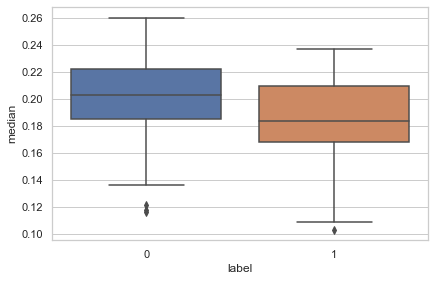

In [22]:
"""
Creating new features
I have done two new things. Firstly I have made 'meanfreq','median' and 'mode' to comply by the standard relation->
......................................................................................3Median=2Mean +Mode.........................................................................
For this I have adjusted values in the 'median' column as shown below. You can alter values in any of the other column say the 'meanfreq' column.¶
"""
temp_df['meanfreq']=temp_df['meanfreq'].apply(lambda x:x*2)
temp_df['median']=temp_df['meanfreq']+temp_df['mode']
temp_df['median']=temp_df['median'].apply(lambda x:x/3)

sns.boxplot(data=temp_df,y='median',x='label') # seeing the new 'median' against the 'label'.

<AxesSubplot:xlabel='label', ylabel='pear_skew'>

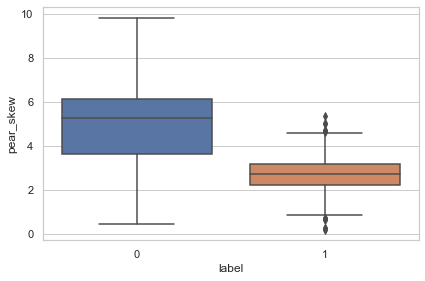

In [23]:
"""
The second new feature that I have added is a new feature to mesure the 'skewness'.
For this I have used the 'Karl Pearson Coefficent' which is calculated as shown below->
..........................................................Coefficent = (Mean - Mode )/StandardDeviation......................................................
You can also try some other coefficient also and see how it compares with the target i.e. the 'label' column.
"""

temp_df['pear_skew']=temp_df['meanfreq']-temp_df['mode']
temp_df['pear_skew']=temp_df['pear_skew']/temp_df['sd']
temp_df.head(10)

sns.boxplot(data=temp_df,y='pear_skew',x='label') # plotting new 'skewness' against the 'label'.

0.9573170731707317
0.9664634146341463


<AxesSubplot:xlabel='Accuracy', ylabel='Modelling Algo'>

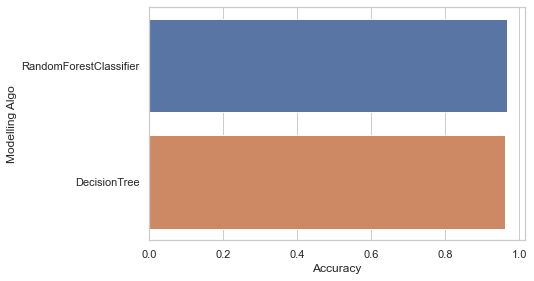

In [31]:
#Preparing the Data
scaler=StandardScaler()
scaled_df=scaler.fit_transform(temp_df.drop('label',axis=1))
X=scaled_df
Y=df['label']
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.20,random_state=20)

clf_dt=DecisionTreeClassifier()
clf_dt.fit(x_train,y_train)
pred=clf_dt.predict(x_test)
print(accuracy_score(pred,y_test))

clf_rf=RandomForestClassifier()
clf_rf.fit(x_train,y_train)
pred=clf_rf.predict(x_test)
print(accuracy_score(pred,y_test))

#We can now move onto comparing the results of various modelling algorithms. for tthis I shall combine the results of all models in a data frame and then plot using a barplot 
models=[RandomForestClassifier(), DecisionTreeClassifier()]

model_names=['RandomForestClassifier','DecisionTree']

acc=[]
d={}

for model in range(len(models)):
    clf=models[model]
    clf.fit(x_train,y_train)
    pred=clf.predict(x_test)
    acc.append(accuracy_score(pred,y_test))
     
d={'Modelling Algo':model_names,'Accuracy':acc}

acc_frame=pd.DataFrame(d)
acc_frame
sns.barplot(y='Modelling Algo',x='Accuracy',data=acc_frame)

In [32]:
#tuning
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, scoring='accuracy', cv= 5)
CV_rfc.fit(x_train, y_train)


print("Best score : ",CV_rfc.best_score_)
print("Best Parameters : ",CV_rfc.best_params_)
print("Precision Score : ", precision_score(CV_rfc.predict(x_test),y_test))


Best score :  0.9854786347284372
Best Parameters :  {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 200}
Precision Score :  0.9764705882352941


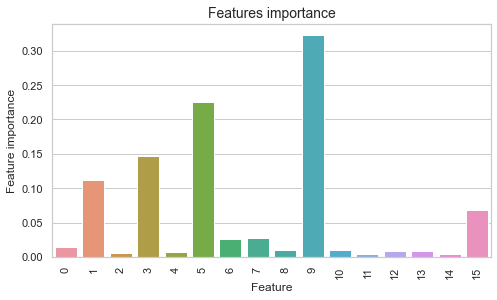

In [33]:
df1 = pd.DataFrame.from_records(x_train)     
tmp = pd.DataFrame({'Feature': df1.columns, 'Feature importance': clf_rf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

In [ ]:
### What is the 9th features?

In [ ]:
### Try it with different classifier: Logistic Regression, SVM, XGBoost